In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader

import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The following dataset computes the noise standard deviation based on the formula provided [here](https://bigwww.epfl.ch/sage/soft/snr/). It computes the standard deviation for each sample rather than using global dataset statistics.

$$
\text{SNR}_{\text{dB}} = 10 \cdot \log_{10}\left(\frac{\sum r^2}{\sum n^2}\right) = 10 \cdot \log_{10}\left(\frac{\text{mean of squared pixel values}}{\text{variance of noise}}\right)
$$

- $ r $: Clean image pixels  
- $ n $: Noise
     
$$
\sigma_{\text{noise}} = \sqrt{\text{mean of squared pixel values} \times10^{-\text{SNR}_{\text{dB}}/10}}
$$

In the above calculations, it was assumed that the noise have a mean equal to zero. Also, the noise variance was computed through division by $\frac{1}{n}$ rather $\frac{1}{n-1}$ which should be valid given we are dealing with the noise sample statistics, thereby Bessel correction is not required.



In [ ]:
class KappaDataset(Dataset):
    def __init__(self, kappa_samples, snr_db=20):
        """
        Args:
            kappa_samples: numpy array of shape (N, H, W)
            snr_db: target SNR in decibels
        """
        # Convert to tensor and normalize globally to [0, 1]
        self.kappa_samples = torch.tensor(kappa_samples, dtype=torch.float32)
        self.min = self.kappa_samples.min()
        self.max = self.kappa_samples.max()
        self.kappa_samples = (self.kappa_samples - self.min) / (self.max - self.min)
        self.snr_db = snr_db

        self.mean2 = torch.mean(self.kappa_samples ** 2, dim=(1, 2))

        # Precompute noise std for each sample
        self.sigma_noise = torch.sqrt(self.mean2 * (10 ** (-self.snr_db / 10)))

    def __len__(self):
        return len(self.kappa_samples)

    def __getitem__(self, idx):
        clean = self.kappa_samples[idx]  # Shape [H, W]
        noise = torch.randn_like(clean) * self.sigma_noise[idx]
        noisy = clean + noise
        return noisy, clean

In [ ]:
# Symmetric Autoencoder with Skip Connections for 32x32 inputs
class KappaDenoiser(nn.Module):
    def __init__(self, latent_dim=128):
        super(KappaDenoiser, self).__init__()

        # Encoder blocks
        # Block 1: 32x32 -> 16x16
        self.enc1_down = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.enc1_relu = nn.ReLU(inplace=True)

        # Block 2: 16x16 -> 8x8
        self.enc2_down = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.enc2_relu = nn.ReLU(inplace=True)

        # Block 3: 8x8 -> 4x4
        self.enc3_down = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc3_relu = nn.ReLU(inplace=True)

        self.enc_flat = nn.Flatten()
        self.enc_linear = nn.Linear(4 * 4 * 128, latent_dim)

        # Decoder blocks

        self.dec_linear = nn.Linear(latent_dim, 4 * 4 * 128)
        self.dec_unflat = nn.Unflatten(1, (128, 4, 4))

        # Block 3: 4x4 -> 8x8
        self.dec3_up = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec3_relu = nn.ReLU(inplace=True)

        # Block 2: 8x8 -> 16x16
        self.dec2_up = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec2_relu = nn.ReLU(inplace=True)

        # Block 1: 16x16 -> 32x32
        self.dec1_up = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)
        self.dec1_relu = nn.ReLU(inplace=True)

    def forward(self, x):

        # Make sure x has the right shape (add channel dimension if needed)
        if len(x.shape) == 3:
            x = x.unsqueeze(1)  # Add channel dimension

        # Encoder path with stored activations for skip connections

        enc = self.enc1_down(x)
        enc = self.enc1_relu(enc)

        enc = self.enc2_down(enc)
        enc = self.enc2_relu(enc)
        enc_skip2 = enc  # Store for skip connection

        enc = self.enc3_down(enc)
        enc = self.enc3_relu(enc)
        enc_skip3 = enc  # Store for skip connection

        # Flatten and linear layer
        enc = self.enc_flat(enc)
        enc = self.enc_linear(enc)

        # Decoder path with skip connections

        dec = self.dec_linear(enc)
        dec = self.dec_unflat(dec)

        dec = dec + enc_skip3  # Skip connection
        dec = self.dec3_up(dec)
        dec = self.dec3_relu(dec)

        dec = dec + enc_skip2  # Skip connection
        dec = self.dec2_up(dec)
        dec = self.dec2_relu(dec)

        dec = self.dec1_up(dec)
        dec = self.dec1_relu(dec)

        return dec

In [ ]:
def train_denoiser(kappa_data, snr_db=5, batch_size=64,
                  epochs=20, lr=0.001, latent_dim=128):
    """
    Train a denoising autoencoder with SNR-controlled noise

    Args:
        kappa_data: numpy array of clean kappa fields (N x 32 x 32)
        snr_db: target signal-to-noise ratio in decibels
    """
    # Create dataset with specified SNR
    dataset = KappaDataset(kappa_data, snr_db=snr_db)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    model = KappaDenoiser(latent_dim=latent_dim).to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=lr)

    # Training loop
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for noisy_kappa, clean_kappa in progress_bar:
            # Move data to device
            noisy_kappa = noisy_kappa.to(device)
            clean_kappa = clean_kappa.to(device)

            # Add channel dimension if needed
            if len(noisy_kappa.shape) == 3:
                noisy_kappa = noisy_kappa.unsqueeze(1)
            if len(clean_kappa.shape) == 3:
                clean_kappa = clean_kappa.unsqueeze(1)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(noisy_kappa)

            # Compute loss
            loss = criterion(outputs, clean_kappa)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        # Print epoch statistics
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

        # Visualize progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            visualize_denoising(model, dataset, device)

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.show()

    return model

In [ ]:
# Visualization function to check denoising performance
def visualize_denoising(model, dataset, device, num_samples=3):
    model.eval()

    plt.figure(figsize=(15, 5 * num_samples))

    with torch.no_grad():
        for i in range(num_samples):

            # Get a random sample from the dataset
            idx = np.random.randint(0, len(dataset))
            noisy_kappa, clean_kappa = dataset[idx]

            # Move to device and add dimensions
            noisy_kappa = noisy_kappa.unsqueeze(0).unsqueeze(0).to(device) # [32,32] -> [1,1,32,32]

            # Apply denoiser
            denoised_kappa = model(noisy_kappa)                            # Output is [1,1,32,32]
            denoised_kappa = denoised_kappa.squeeze(0).squeeze(0).cpu()    # [1,1,32,32] -> [32,32]

            # Move everything to CPU for plotting
            noisy_kappa = noisy_kappa.squeeze(0).squeeze(0).cpu()          # [1,1,32,32] -> [32,32]
            clean_kappa = clean_kappa.cpu()

            # Plot
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(clean_kappa, cmap='viridis')
            plt.title(f"Clean kappa #{idx}")
            plt.colorbar()

            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(noisy_kappa, cmap='viridis')
            plt.title(f"Noisy kappa (SNR={dataset.snr_db})")
            plt.colorbar()

            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(denoised_kappa, cmap='viridis')
            plt.title("Denoised kappa")
            plt.colorbar()

    plt.tight_layout()
    plt.show()

Epoch 1/20: 100%|██████████| 313/313 [00:03<00:00, 98.31it/s, loss=0.0075]


Epoch 1/20, Loss: 0.013672


Epoch 2/20: 100%|██████████| 313/313 [00:03<00:00, 92.60it/s, loss=0.00539]


Epoch 2/20, Loss: 0.006280


Epoch 3/20: 100%|██████████| 313/313 [00:02<00:00, 106.88it/s, loss=0.00389]


Epoch 3/20, Loss: 0.004106


Epoch 4/20: 100%|██████████| 313/313 [00:02<00:00, 111.03it/s, loss=0.00297]


Epoch 4/20, Loss: 0.003530


Epoch 5/20: 100%|██████████| 313/313 [00:02<00:00, 112.41it/s, loss=0.00344]


Epoch 5/20, Loss: 0.003270


Epoch 6/20: 100%|██████████| 313/313 [00:03<00:00, 94.83it/s, loss=0.00327]


Epoch 6/20, Loss: 0.003111


Epoch 7/20: 100%|██████████| 313/313 [00:03<00:00, 94.25it/s, loss=0.00274] 


Epoch 7/20, Loss: 0.002999


Epoch 8/20: 100%|██████████| 313/313 [00:02<00:00, 110.43it/s, loss=0.00272]


Epoch 8/20, Loss: 0.002922


Epoch 9/20: 100%|██████████| 313/313 [00:02<00:00, 110.08it/s, loss=0.00279]


Epoch 9/20, Loss: 0.002861


Epoch 10/20: 100%|██████████| 313/313 [00:02<00:00, 108.45it/s, loss=0.00277]


Epoch 10/20, Loss: 0.002816


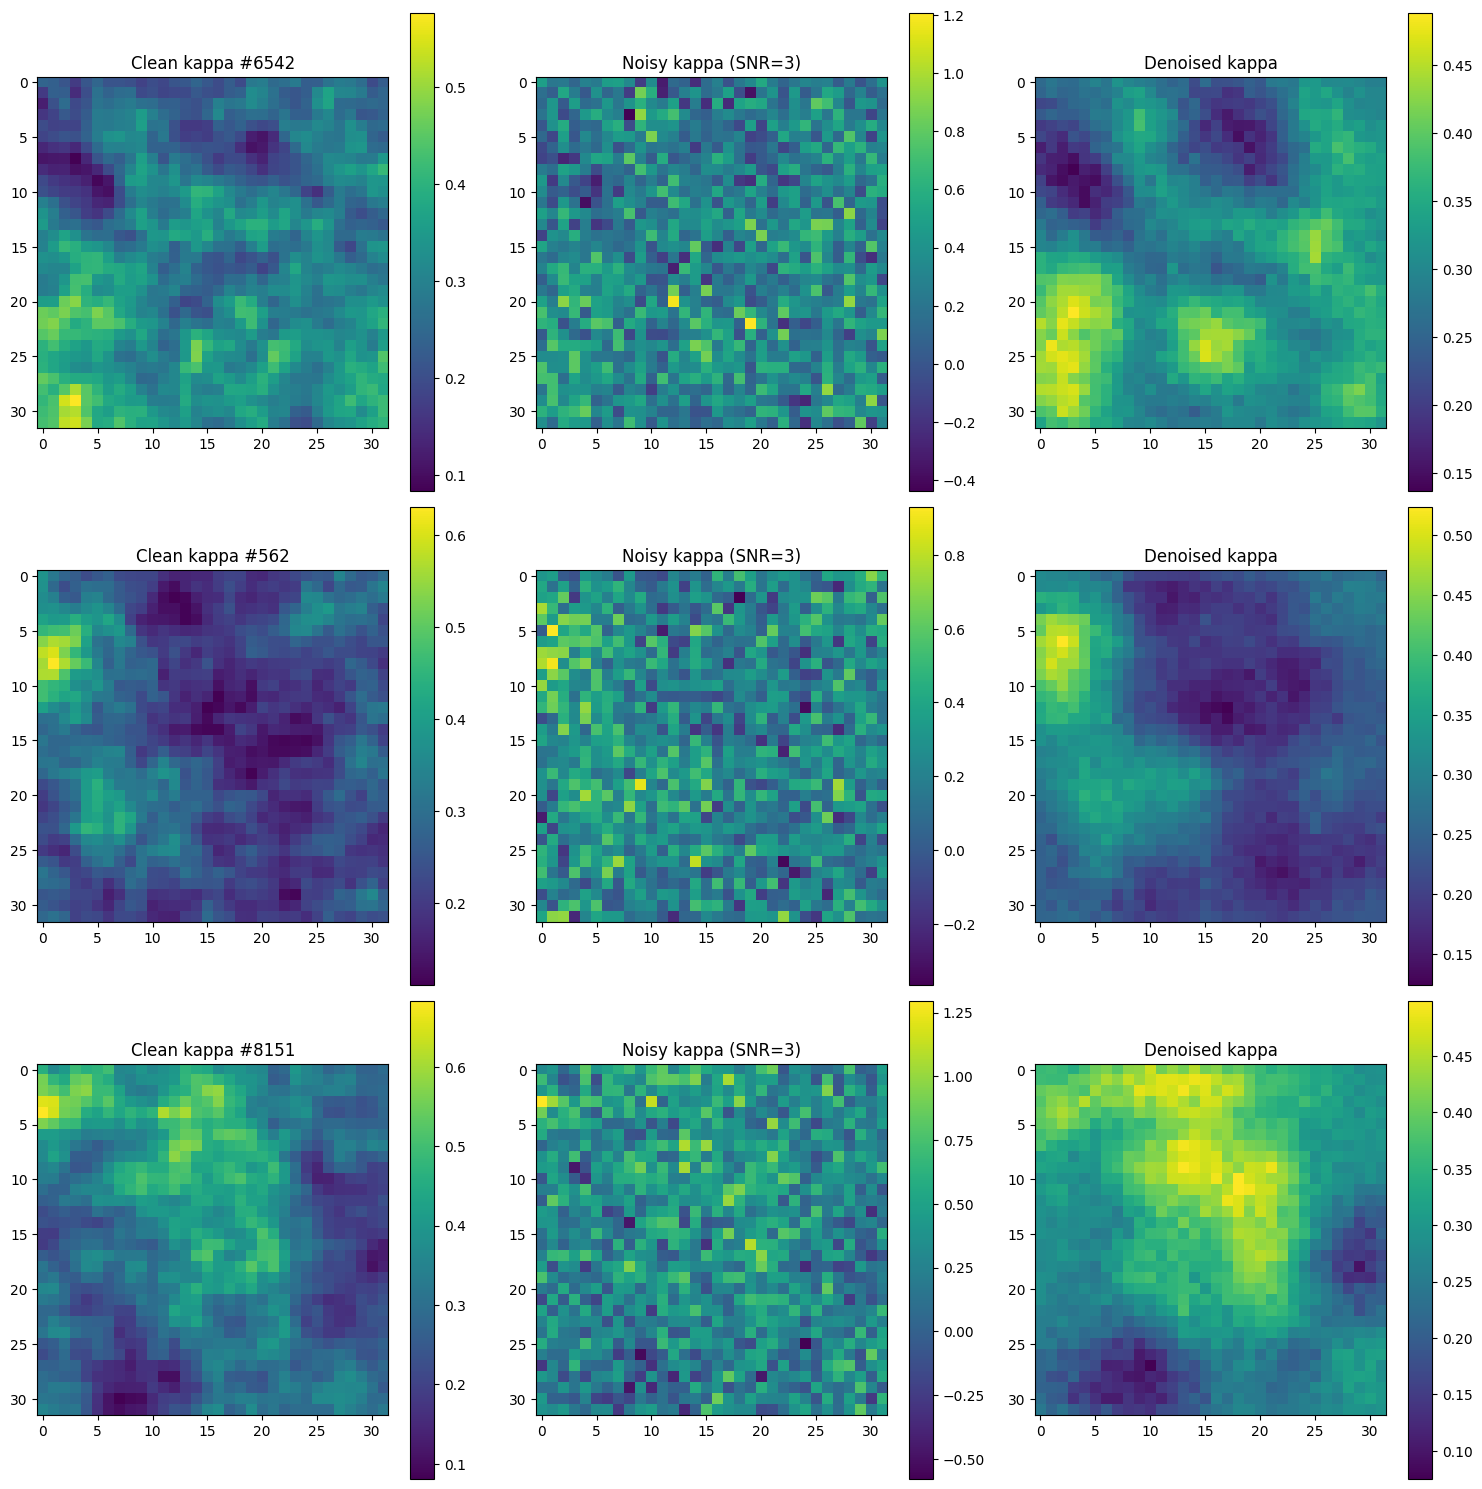

Epoch 11/20: 100%|██████████| 313/313 [00:03<00:00, 86.80it/s, loss=0.00304]


Epoch 11/20, Loss: 0.002779


Epoch 12/20: 100%|██████████| 313/313 [00:02<00:00, 122.89it/s, loss=0.00269]


Epoch 12/20, Loss: 0.002744


Epoch 13/20: 100%|██████████| 313/313 [00:02<00:00, 140.02it/s, loss=0.00276]


Epoch 13/20, Loss: 0.002718


Epoch 14/20: 100%|██████████| 313/313 [00:02<00:00, 121.64it/s, loss=0.00254]


Epoch 14/20, Loss: 0.002697


Epoch 15/20: 100%|██████████| 313/313 [00:03<00:00, 90.30it/s, loss=0.00223]


Epoch 15/20, Loss: 0.002672


Epoch 16/20: 100%|██████████| 313/313 [00:03<00:00, 79.77it/s, loss=0.00259]


Epoch 16/20, Loss: 0.002658


Epoch 17/20: 100%|██████████| 313/313 [00:03<00:00, 85.96it/s, loss=0.00254]


Epoch 17/20, Loss: 0.002640


Epoch 18/20: 100%|██████████| 313/313 [00:03<00:00, 93.13it/s, loss=0.00278]


Epoch 18/20, Loss: 0.002629


Epoch 19/20: 100%|██████████| 313/313 [00:03<00:00, 93.04it/s, loss=0.00242]


Epoch 19/20, Loss: 0.002615


Epoch 20/20: 100%|██████████| 313/313 [00:03<00:00, 89.03it/s, loss=0.00259]


Epoch 20/20, Loss: 0.002610


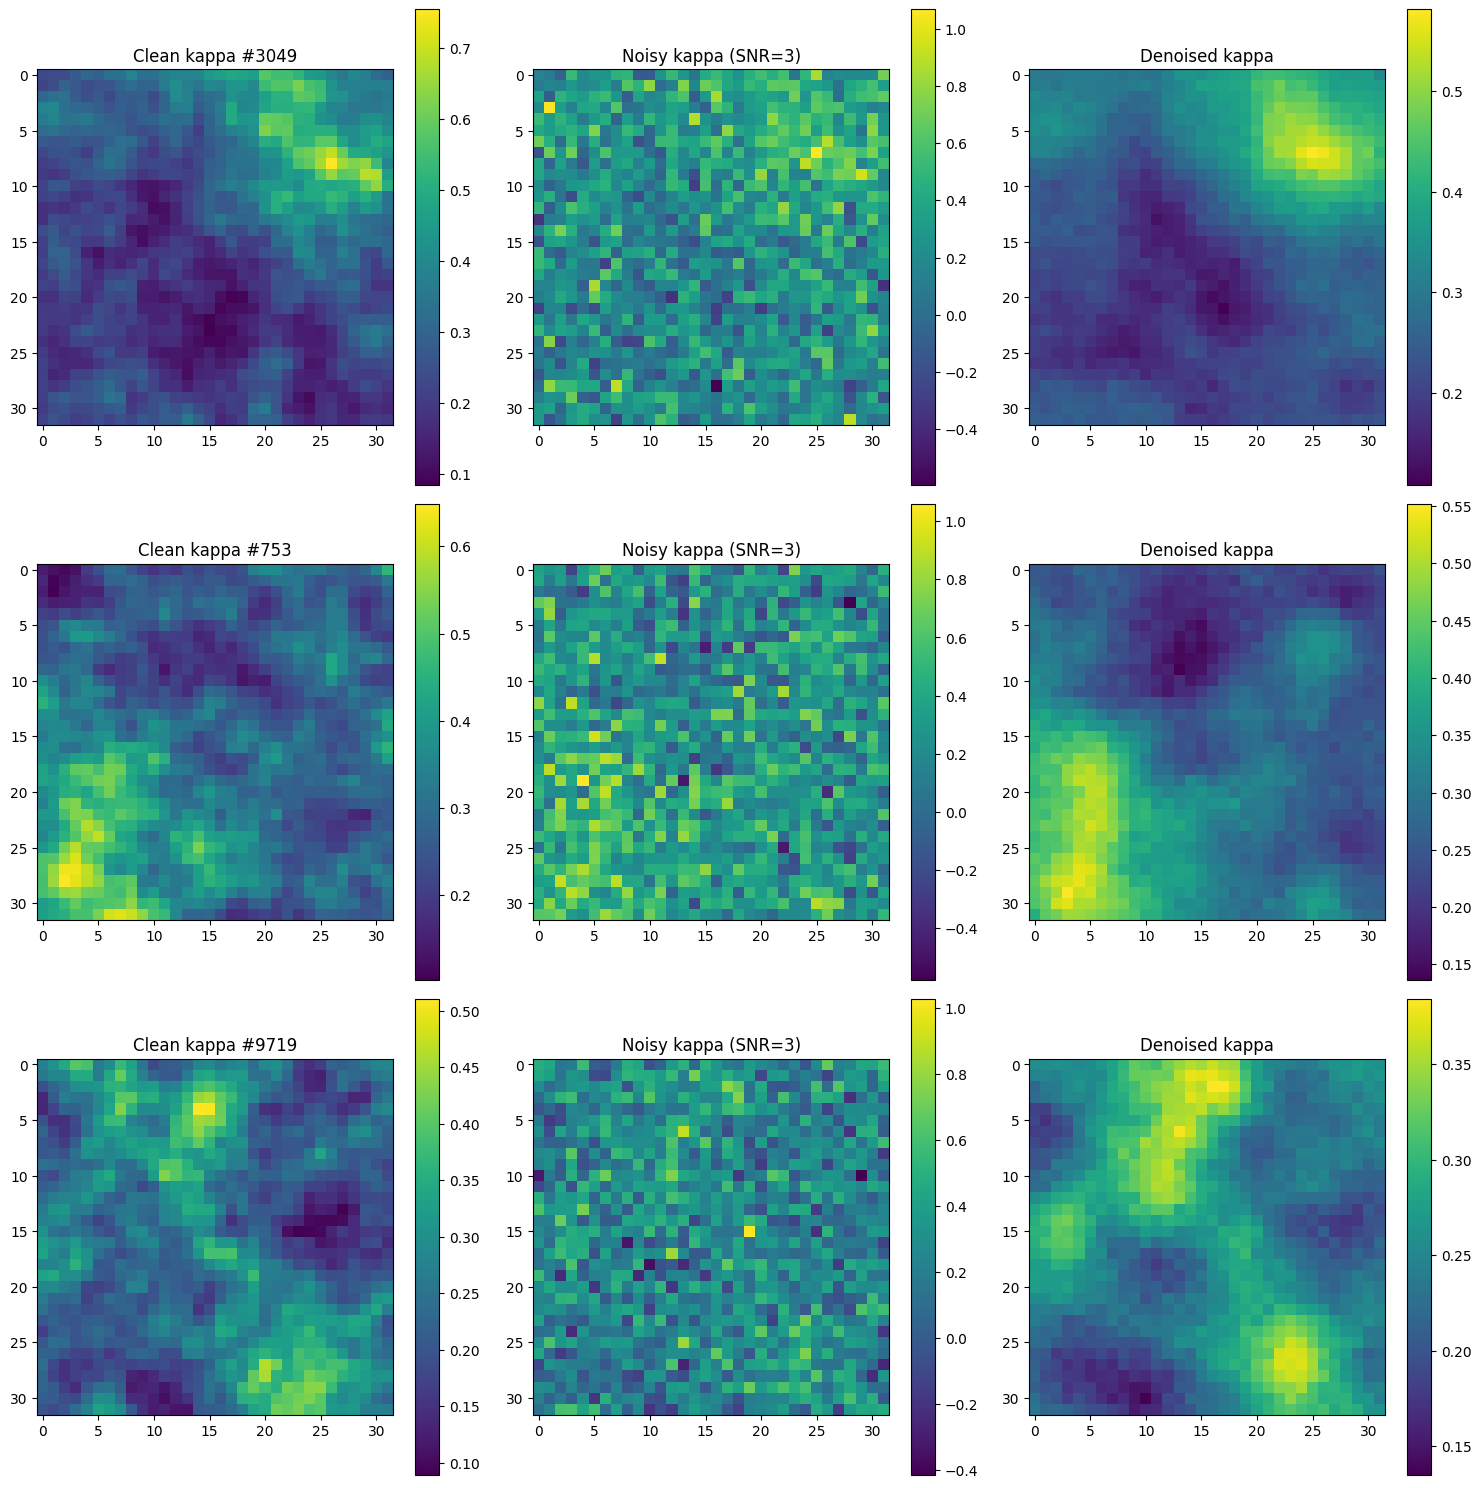

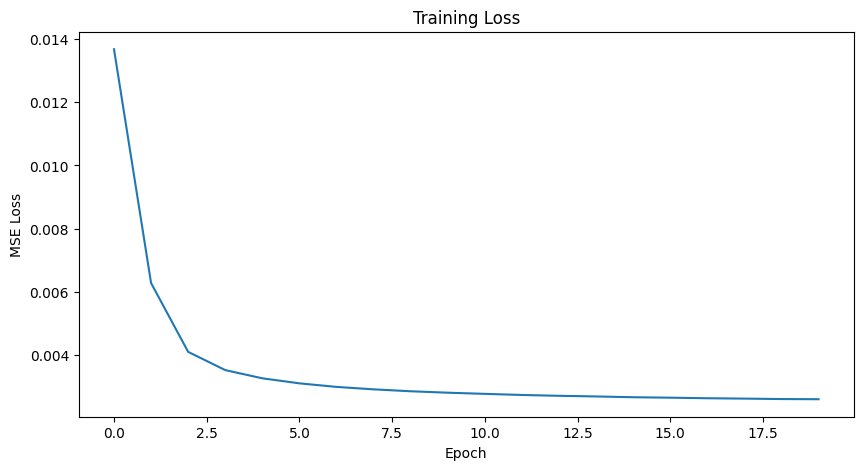

In [ ]:
kappa_samples = np.load("/content/drive/MyDrive/kappa_fine_samples.npy")

resized_kappa = np.zeros((10000, 32, 32))
for i in range(kappa_samples.shape[0]):
    resized_kappa[i] = cv2.resize(kappa_samples[i], (32, 32))

# Train denoiser
snr_db = 3
model = train_denoiser(
    resized_kappa,
    snr_db=snr_db,
    batch_size=32,
    epochs=20,
    lr=0.00001,
    latent_dim=128
)

# Save the model
torch.save(model.state_dict(), "kappa_denoiser.pt")